### Project objective: Leverage twitter data, and using pre-labeled text which identifies if a tweet is in reference to a natural disaster, determine which tweets in a set of unlabelled data are also regarding natural disasters.  To accomplish this, two models will be attempted.  One, using purely word data as input, and the second, a more complex RNN model which will take phrases into consideration.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score
#from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Concatenate, Dropout, Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"


    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 

In [3]:
wd = os.getcwd()

In [4]:
train_df = pd.read_csv(wd + "/Data/train.csv")
test_df = pd.read_csv(wd + "/Data/test.csv")

In [5]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [6]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [7]:
train, val = train_test_split(train_df, test_size=0.2, random_state=2)

In [8]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
train_vectors = count_vectorizer.fit_transform(train["text"])

In [9]:
train_df['word count'] = train_df['text'].apply(lambda x: len(x.split()))

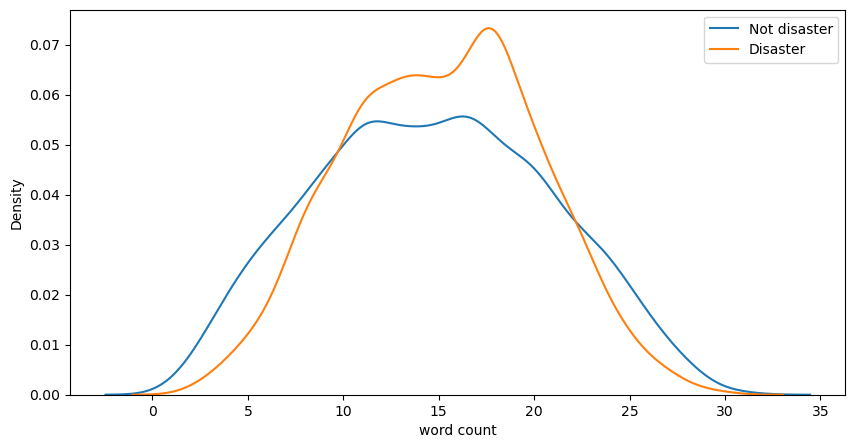

In [10]:
fig, ax = plt.subplots(figsize = (10, 5))

sns.kdeplot(train_df['word count'][train_df['target'] == 0], label = 'Not disaster')
sns.kdeplot(train_df['word count'][train_df['target'] == 1], label = 'Disaster')
plt.legend()

### Disaster tweets have less range than the broader population

In [12]:
train_vectors = count_vectorizer.fit_transform(train["text"])
val_vectors = count_vectorizer.transform(val["text"])
test_vectors = count_vectorizer.transform(test_df["text"])

In [13]:
clf = linear_model.RidgeClassifier()

In [14]:
clf.fit(train_vectors, train["target"])
train_output = clf.predict(train_vectors)

val_output = clf.predict(val_vectors)


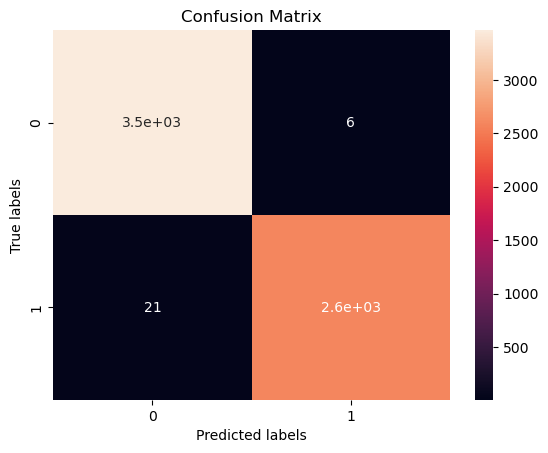

In [15]:
plot_confusion_matrix(train["target"], train_output)

In [16]:
print("acc: ", accuracy_score(train["target"], train_output))

acc:  0.9955665024630542


### Accuracy on the training set is very precise, which is somewhat expected

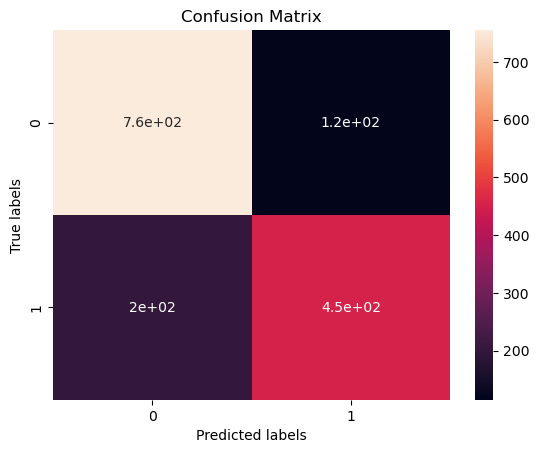

In [17]:
plot_confusion_matrix(val["target"], val_output)

In [18]:
print("acc: ", accuracy_score(val["target"], val_output))

acc:  0.7931713722915299


### Less accurate on the validation dataset

### Model Build #2: LTSM on phrases

In [28]:

#define tokenizer options
tokenizer = Tokenizer()     

tokenizer.fit_on_texts(train['text'])

# Identifies phrases, or sequences of words
sequences_train = tokenizer.texts_to_sequences(train['text'])
sequences_val = tokenizer.texts_to_sequences(val['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_train = pad_sequences(sequences_train)
data_val = pad_sequences(sequences_val, maxlen=len(data_train[0]))
train_labels = train['target']
val_labels = val['target']
print('Shape of data tensor:', data_train.shape)
print('Shape of label tensor:', train_labels.shape)

nlp_train = data_train[:len(train)]
nlp_test = data_train[len(train):]
nlp_val = data_val[:len(val)]

MAX_SEQUENCE_LENGTH = data_train.shape[1]

Found 19321 unique tokens.
Shape of data tensor: (6090, 33)
Shape of label tensor: (6090,)


In [29]:
# Embedding turns positive integers (indexes) into dense vectors of fixed size.
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, 
                     trainable = False)  

In [30]:
#function to create lstm model
    
spatial_dropout = .2
dropout = .2
recurrent_dropout = .2
learning_rate = 3e-4
bidirectional = True

activation = 'ReLU'

#define inputs
nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')

emb = embedding(nlp_input)
emb = SpatialDropout1D(dropout)(emb)

#add LSTM layer
if bidirectional:
    nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                             kernel_initializer = 'orthogonal')))(emb)
else:
    nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                             kernel_initializer = 'orthogonal'))(emb)        


x = nlp_out

#add output layer
x = Dropout(dropout)(x)
preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)

#compile model
model = Model(inputs=[nlp_input ], outputs = preds)
optimizer = Adam(learning_rate = learning_rate)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])


In [31]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ nlp_input (InputLayer)               │ (None, 33)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 33, 300)             │       5,796,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 33, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200)                 │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,117,601 (23.34 MB)

 Trainable params: 6,117,601 (23.34 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history1 = model.fit([nlp_train], train_labels, validation_split = .2,
                       epochs = 10, batch_size = 21, verbose = 1)

Epoch 1/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.5958 - loss: 0.6601 - val_accuracy: 0.7011 - val_loss: 0.5564
Epoch 2/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.8147 - loss: 0.4378 - val_accuracy: 0.8210 - val_loss: 0.4212
Epoch 3/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.9139 - loss: 0.2459 - val_accuracy: 0.8194 - val_loss: 0.4498
Epoch 4/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.9503 - loss: 0.1408 - val_accuracy: 0.8005 - val_loss: 0.4814
Epoch 5/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9690 - loss: 0.0987 - val_accuracy: 0.7841 - val_loss: 0.5786
Epoch 6/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9789 - loss: 0.0644 - val_accuracy: 0.7800 - val_loss: 0.6877
Epoch 7/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9876 - loss: 0.0447 - val_accuracy: 0.7857 - val_loss: 0.8276
Epoch 8/10
232/232 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9911 - loss: 0.0319 - 

In [36]:
val_predictions = model.predict(nlp_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [37]:
val_predictions2 = np.where(val_predictions > 0.5,1,0)

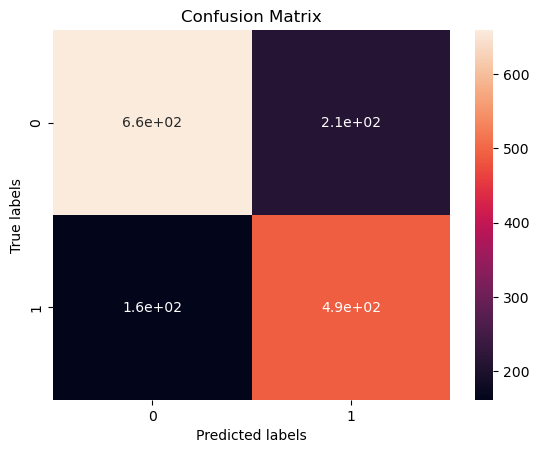

In [38]:
plot_confusion_matrix(val["target"], val_predictions2)  

In [39]:
print("acc: ", accuracy_score(val["target"], val_predictions2))

acc:  0.7550886408404465


### In conclusion, curiously the model which took individual words as input was more accurate than the LTSM model which took phases, or sequences of words as the input.  The opportunity here to is further clean the data, outliers and misspelled words.

In [40]:
submission = pd.DataFrame()
submission['id'] = test_df['id']
submission['target'] = clf.predict(test_vectors)
submission.to_csv("submission.csv", index=False)